# Projet Classification Vaccination

Ronan KIELT, James ABIB AMMAN AMIR, Vithushan ARULBALAN, Charles CRETOIS

## Introduction

Prédire la probabilité qu'une personne ait reçu ou non les vaccins contre la grippe H1N1 et la grippe saisonnière. Il y aura deux variables cibles (binaires : oui/non), ce qui correspond à un problème de classification supervisée.

## 1. Importation des bibliothèques et chargement des données

In [449]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.multioutput import MultiOutputClassifier
import warnings
warnings.filterwarnings('ignore')

In [450]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

#### Chargement des données

In [451]:
X = pd.read_csv("sup/X.csv")
y = pd.read_csv("sup/y.csv")

print("Dimensions des données :")
print(f"X : {X.shape}")
print(f"y : {y.shape}")

Dimensions des données :
X : (26707, 36)
y : (26707, 3)


## 2. Préparation complète des données

### 2.1 Présentation des données (variables, dimensions, types)

#### Affichage des premières lignes


In [452]:
print("\nAperçu des features :")
print(X.head())
print("\nAperçu des targets :")
print(y.head())


Aperçu des features :
   respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                     

#### Types de données

In [453]:
print("\nTypes de variables dans X :")
print(X.dtypes.value_counts())


Types de variables dans X :
float64    23
object     12
int64       1
Name: count, dtype: int64


#### Séparation des variables numériques et catégorielles

In [454]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('respondent_id')  # Retirer l'ID
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNombre de variables numériques : {len(numerical_features)}")
print(f"Nombre de variables catégorielles : {len(categorical_features)}")


Nombre de variables numériques : 23
Nombre de variables catégorielles : 12


#### Description des variables cibles

In [455]:
print("\nDistribution des variables cibles :")
print("H1N1 vaccine :")
print(y['h1n1_vaccine'].value_counts(normalize=True))
print("\nSeasonal vaccine :")
print(y['seasonal_vaccine'].value_counts(normalize=True))


Distribution des variables cibles :
H1N1 vaccine :
h1n1_vaccine
0    0.787546
1    0.212454
Name: proportion, dtype: float64

Seasonal vaccine :
seasonal_vaccine
0    0.534392
1    0.465608
Name: proportion, dtype: float64


#### Analyse des valeurs manquantes

In [456]:
missing_values = X.isnull().sum()
missing_percentage = (missing_values / len(X)) * 100
missing_df = pd.DataFrame({
    'Variable': missing_values.index,
    'Missing_Count': missing_values.values,
    'Percentage': missing_percentage.values
}).sort_values('Percentage', ascending=False)

print("\nTop 10 variables avec le plus de valeurs manquantes :")
print(missing_df.head(10))


Top 10 variables avec le plus de valeurs manquantes :
                 Variable  Missing_Count  Percentage
35  employment_occupation          13470   50.436215
34    employment_industry          13330   49.912008
15       health_insurance          12274   45.957989
26         income_poverty           4423   16.561201
10       doctor_recc_h1n1           2160    8.087767
11   doctor_recc_seasonal           2160    8.087767
28            rent_or_own           2042    7.645936
29      employment_status           1463    5.477965
27         marital_status           1408    5.272026
23              education           1407    5.268282


#### Visualisation des valeurs manquantes

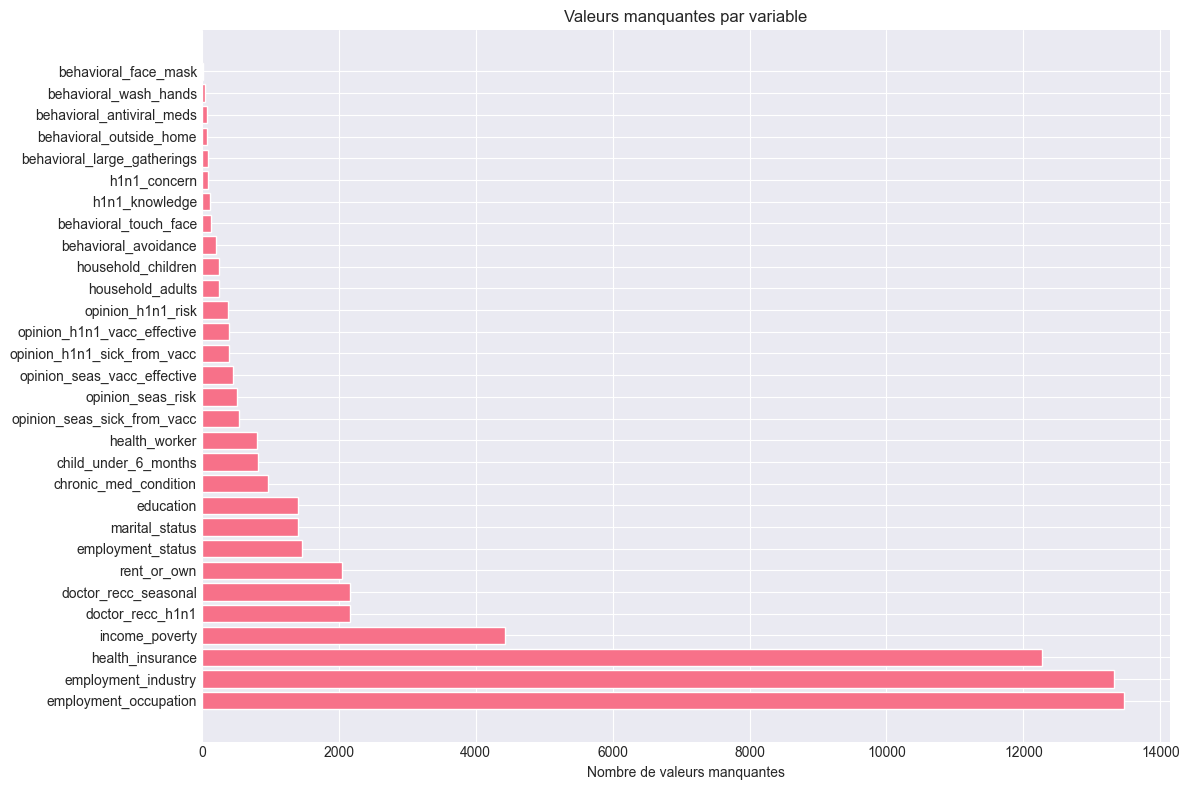

In [457]:
plt.figure(figsize=(12, 8))
missing_data = X.isnull().sum()[X.isnull().sum() > 0].sort_values(ascending=False)
plt.barh(missing_data.index, missing_data.values)
plt.xlabel('Nombre de valeurs manquantes')
plt.title('Valeurs manquantes par variable')
plt.tight_layout()
plt.show()

### 2.2 Traitement des valeurs manquantes

#### Stratégie de traitement :
 - Variables numériques : imputation par la médiane
 - Variables catégorielles : imputation par le mode


#### Création des imputeurs

In [458]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

#### Application de l'imputation

In [459]:
X_num_imputed = pd.DataFrame(
    num_imputer.fit_transform(X[numerical_features]),
    columns=numerical_features,
    index=X.index
)

X_cat_imputed = pd.DataFrame(
    cat_imputer.fit_transform(X[categorical_features]),
    columns=categorical_features,
    index=X.index
)

#### Reconstitution du dataframe

In [460]:
X_imputed = pd.concat([X[['respondent_id']], X_num_imputed, X_cat_imputed], axis=1)

print("Vérification : nombre de valeurs manquantes après imputation :", X_imputed.isnull().sum().sum())

Vérification : nombre de valeurs manquantes après imputation : 0


### 2.3 Gestion des valeurs aberrantes

#### Détection des outliers pour les variables numériques avec IQR

In [461]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

#### Analyse des outliers pour household_adults et household_children

In [462]:
for col in ['household_adults', 'household_children']:
    n_outliers, lb, ub = detect_outliers_iqr(X_imputed, col)
    print(f"\n{col}: {n_outliers} outliers détectés")
    print(f"Limites: [{lb:.2f}, {ub:.2f}]")
    print(f"Valeurs uniques: {sorted(X_imputed[col].unique())}")


household_adults: 1125 outliers détectés
Limites: [-1.50, 2.50]
Valeurs uniques: [0.0, 1.0, 2.0, 3.0]

household_children: 1747 outliers détectés
Limites: [-1.50, 2.50]
Valeurs uniques: [0.0, 1.0, 2.0, 3.0]


#### Note: Les variables household sont top-coded à 3, donc pas de traitement nécessaire

### 2.4 Sélection pertinente des variables (Feature selection)

#### Analyse de corrélation avec les cibles et fusion temporaire pour l'analyse

In [463]:

data_for_correlation = pd.concat([X_imputed[numerical_features], y[['h1n1_vaccine', 'seasonal_vaccine']]], axis=1)
correlation_with_targets = data_for_correlation.corr()[['h1n1_vaccine', 'seasonal_vaccine']].sort_values('h1n1_vaccine', ascending=False)

print("\nTop 10 corrélations avec h1n1_vaccine :")
print(correlation_with_targets['h1n1_vaccine'].head(10))


Top 10 corrélations avec h1n1_vaccine :
h1n1_vaccine                   1.000000
doctor_recc_h1n1               0.394086
seasonal_vaccine               0.377143
opinion_h1n1_risk              0.320580
opinion_h1n1_vacc_effective    0.267352
opinion_seas_risk              0.255874
doctor_recc_seasonal           0.218976
opinion_seas_vacc_effective    0.177799
health_worker                  0.168056
h1n1_concern                   0.121574
Name: h1n1_vaccine, dtype: float64


#### Visualisation des corrélations importantes

<Figure size 1000x1200 with 0 Axes>

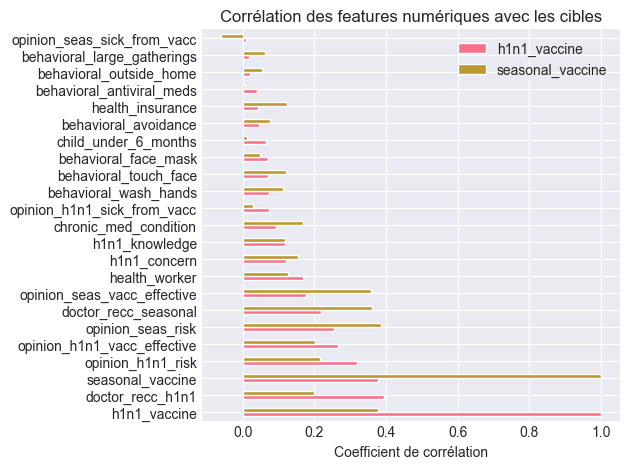

In [464]:
plt.figure(figsize=(10, 12))
correlation_with_targets[:-2].plot(kind='barh')
plt.title('Corrélation des features numériques avec les cibles')
plt.xlabel('Coefficient de corrélation')
plt.tight_layout()
plt.show()

#### Variables importantes identifiées :

In [465]:
important_features = [
    'doctor_recc_h1n1', 'doctor_recc_seasonal', 'health_insurance',
    'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_seas_vacc_effective',
    'h1n1_concern', 'h1n1_knowledge', 'health_worker', 'age_group', 'education'
]


### 2.5 Normalisation et transformation des variables

#### Préparation du pipeline de preprocessing
#### Variables numériques

In [466]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#### Variables catégorielles

In [467]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

#### ColumnTransformer

In [468]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 3. Analyse exploratoire approfondie

### 3.1 Visualisations des variables qualitatives


#### Distribution des variables catégorielles importantes

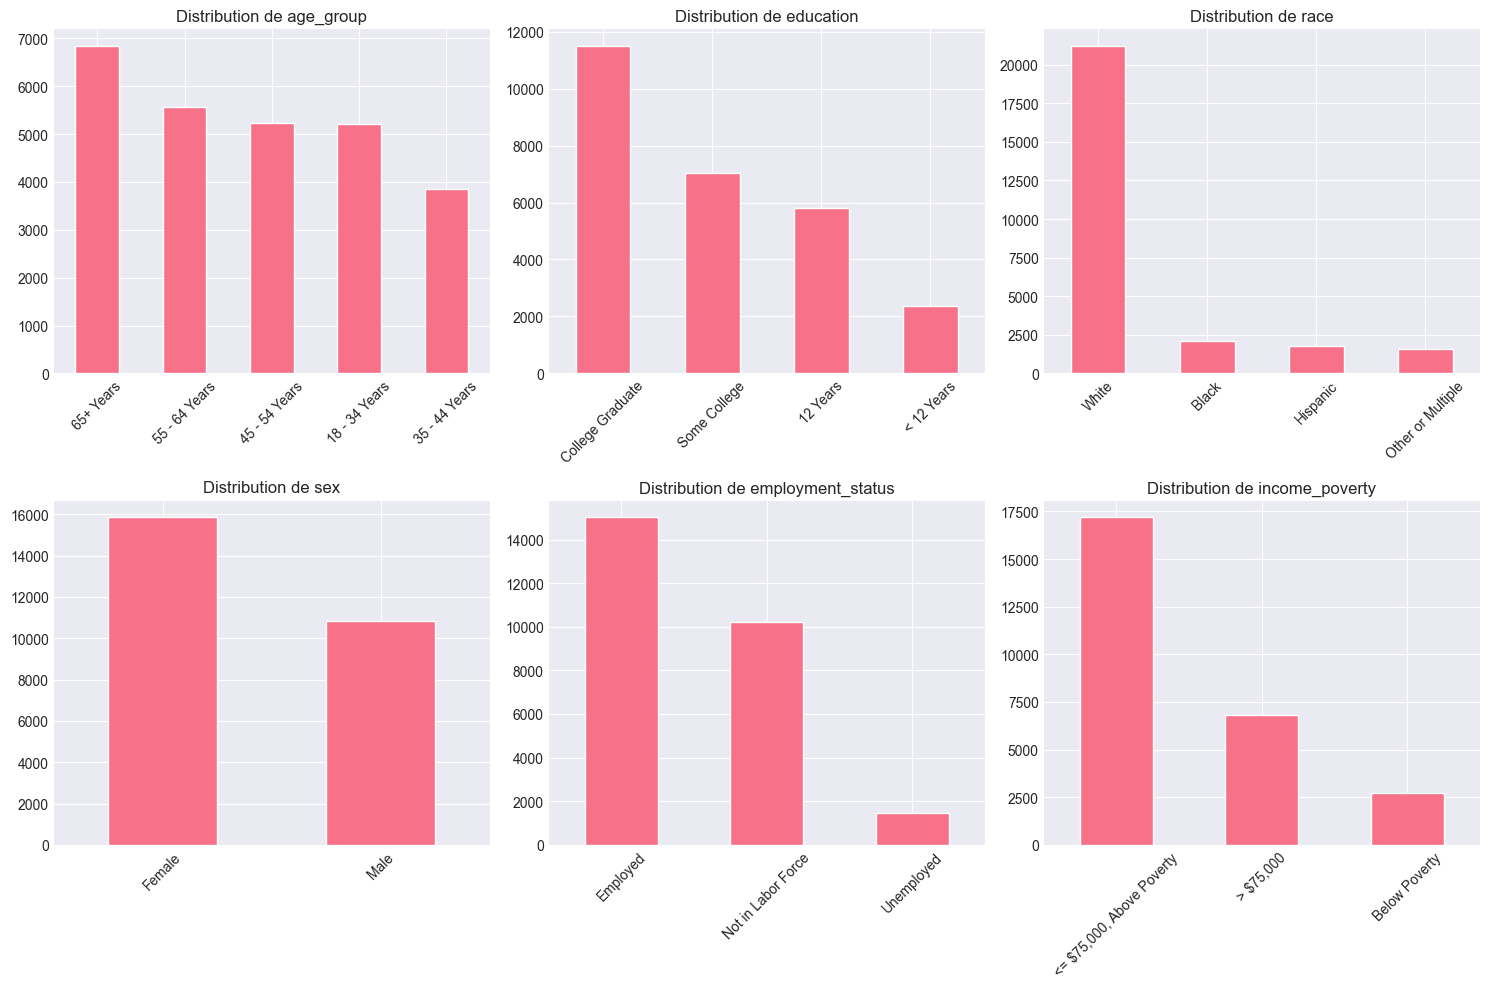

In [469]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

important_cat_vars = ['age_group', 'education', 'race', 'sex', 'employment_status', 'income_poverty']

for idx, var in enumerate(important_cat_vars):
    X_imputed[var].value_counts().plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f'Distribution de {var}')
    axes[idx].set_xlabel('')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 3.2 Visualisations des variables quantitatives

#### Distribution des variables numériques importantes

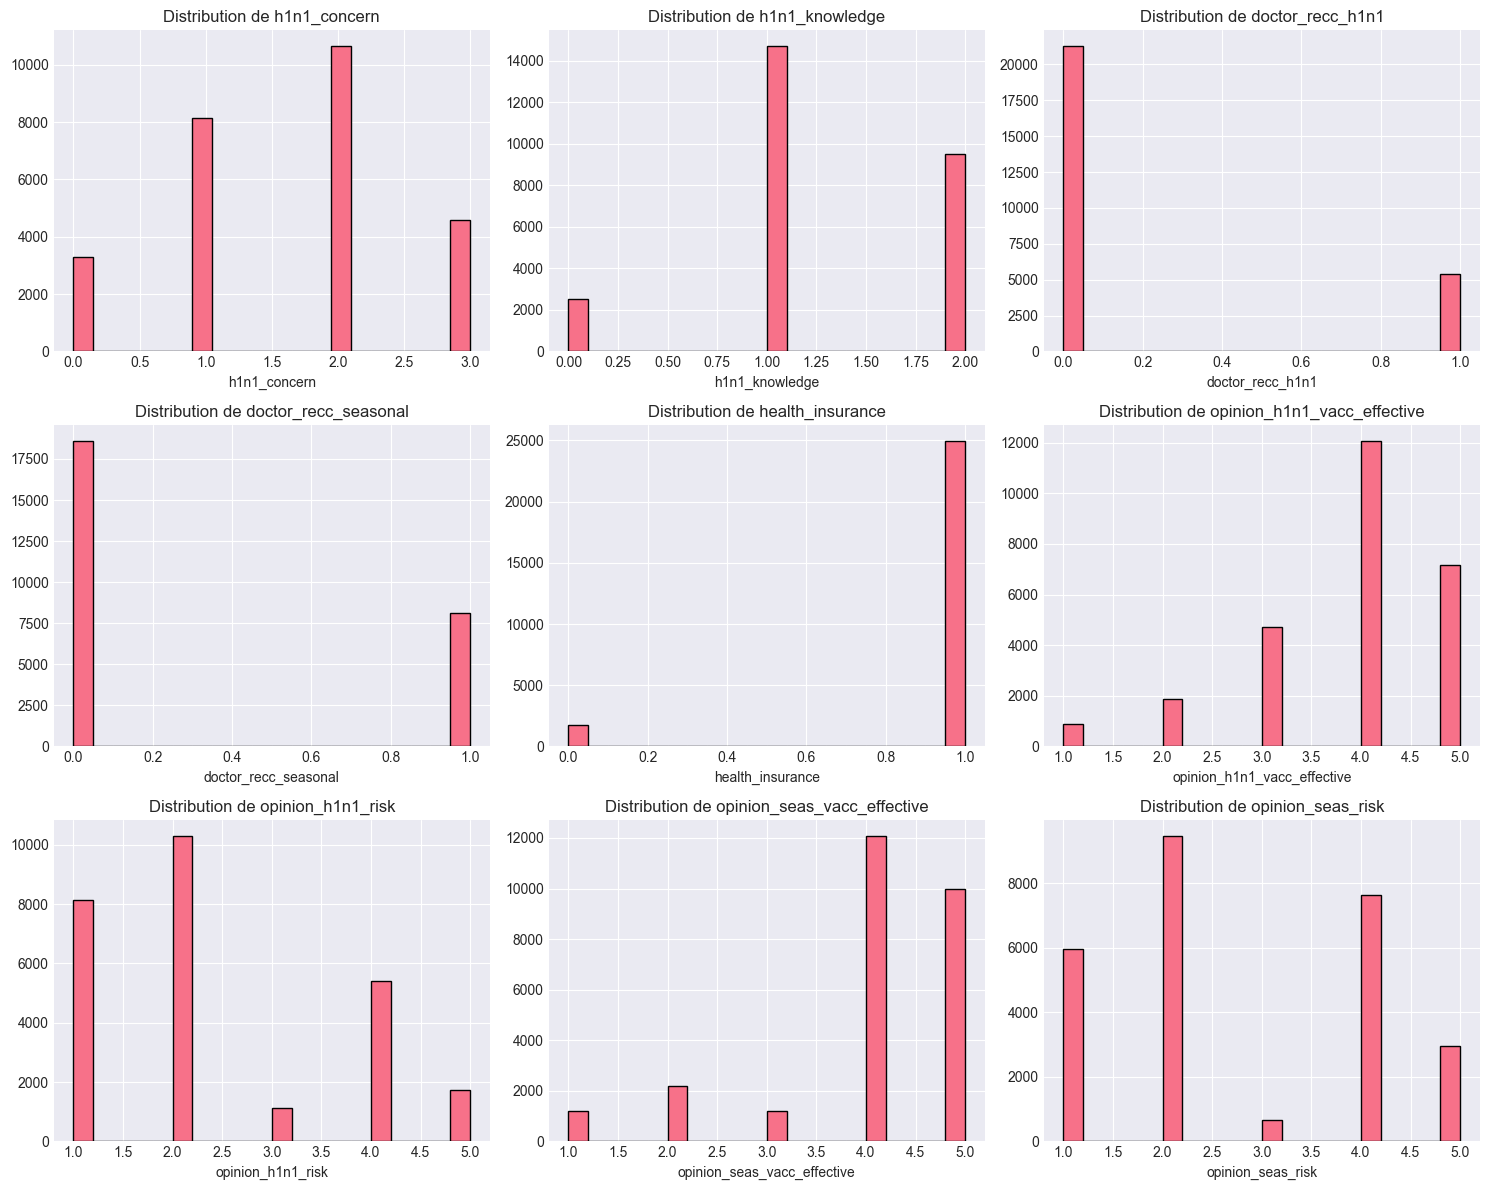

In [470]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

important_num_vars = [
    'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
    'doctor_recc_seasonal', 'health_insurance', 'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk'
]

for idx, var in enumerate(important_num_vars):
    X_imputed[var].hist(ax=axes[idx], bins=20, edgecolor='black')
    axes[idx].set_title(f'Distribution de {var}')
    axes[idx].set_xlabel(var)

plt.tight_layout()
plt.show()

### 3.3 Visualisations croisées (quali x quanti)

#### Analyse de la vaccination selon l'âge et le sexe

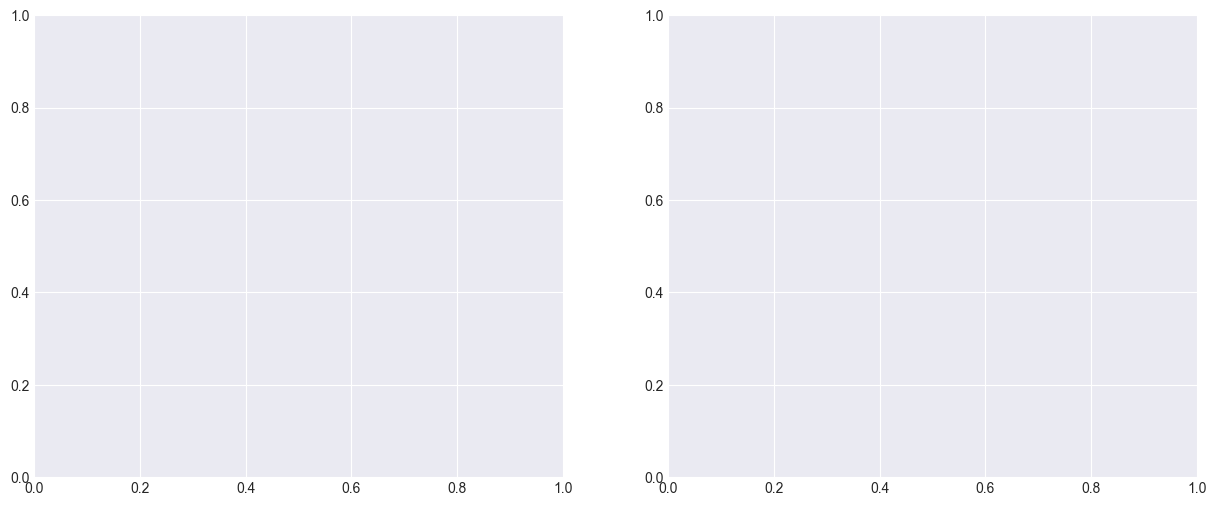

In [471]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#### H1N1 vaccination par groupe d'âge

In [472]:
vaccine_by_age = pd.crosstab(X_imputed['age_group'], y['h1n1_vaccine'], normalize='index')
vaccine_by_age.plot(kind='bar', ax=ax1)
ax1.set_title('Taux de vaccination H1N1 par groupe d\'âge')
ax1.set_xlabel('Groupe d\'âge')
ax1.set_ylabel('Proportion')
ax1.legend(['Non vacciné', 'Vacciné'])

#### Vaccination saisonnière par niveau d'éducation

In [473]:
vaccine_by_edu = pd.crosstab(X_imputed['education'], y['seasonal_vaccine'], normalize='index')
vaccine_by_edu.plot(kind='bar', ax=ax2)
ax2.set_title('Taux de vaccination saisonnière par niveau d\'éducation')
ax2.set_xlabel('Niveau d\'éducation')
ax2.set_ylabel('Proportion')
ax2.legend(['Non vacciné', 'Vacciné'])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

#### Analyse de l'impact de la recommandation du médecin

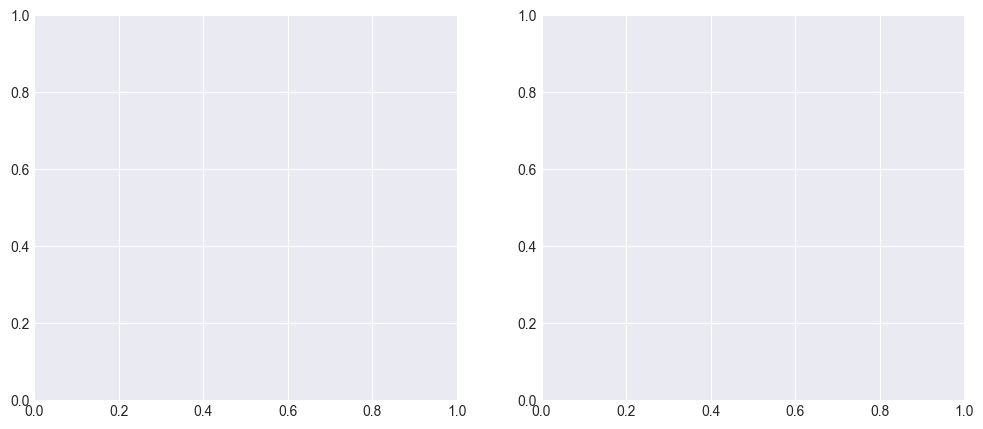

In [474]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#### H1N1

In [475]:
pd.crosstab(X_imputed['doctor_recc_h1n1'], y['h1n1_vaccine'], normalize='index').plot(
    kind='bar', ax=ax1
)
ax1.set_title('Impact de la recommandation du médecin sur la vaccination H1N1')
ax1.set_xlabel('Recommandation du médecin')
ax1.set_ylabel('Proportion')

Text(4.444444444444448, 0.5, 'Proportion')

#### Saisonnière

In [476]:
pd.crosstab(X_imputed['doctor_recc_seasonal'], y['seasonal_vaccine'], normalize='index').plot(
    kind='bar', ax=ax2
)
ax2.set_title('Impact de la recommandation du médecin sur la vaccination saisonnière')
ax2.set_xlabel('Recommandation du médecin')
ax2.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### 3.4 Table de corrélation

#### Matrice de corrélation complète

In [477]:
plt.figure(figsize=(20, 16))
correlation_matrix = X_imputed[numerical_features].corr()

<Figure size 2000x1600 with 0 Axes>

#### Masque pour la moitié supérieure

In [478]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

#### Heatmap

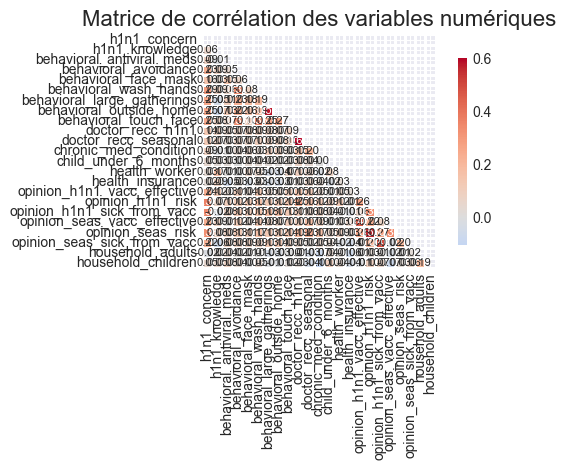

In [479]:
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .8},
            annot=True, fmt='.2f', annot_kws={'size': 8})
plt.title('Matrice de corrélation des variables numériques', fontsize=16)
plt.tight_layout()
plt.show()

#### Corrélations fortes identifiées

In [480]:
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print("\nPaires de variables fortement corrélées (|r| > 0.7) :")
for var1, var2, corr in high_corr_pairs:
    print(f"{var1} - {var2}: {corr:.3f}")


Paires de variables fortement corrélées (|r| > 0.7) :


## 4. Modélisation et évaluation des modèles

#### Préparation des données pour la modélisation

In [481]:
X_prepared = X_imputed.drop('respondent_id', axis=1)
y_prepared = y[['h1n1_vaccine', 'seasonal_vaccine']]

#### Division train/test

In [482]:
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y_prepared, test_size=0.2, random_state=42, stratify=y_prepared
)

print(f"Taille du jeu d'entraînement : {X_train.shape}")
print(f"Taille du jeu de test : {X_test.shape}")

Taille du jeu d'entraînement : (21365, 35)
Taille du jeu de test : (5342, 35)


### 4.1 Modèle 1 : Régression logistique

#### Évaluation (ROC/AUC, précision, rappel, F-score)

#### Pipeline avec preprocessing et modèle

In [483]:
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42)))
])

#### Entraînement

In [484]:
print("Entraînement de la régression logistique...")
logreg_pipeline.fit(X_train, y_train)

Entraînement de la régression logistique...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   '...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                    random_state=42)))])

#### Prédictions

In [485]:
y_pred_logreg = logreg_pipeline.predict_proba(X_test)

#### Extraction des probabilités pour la classe positive

In [486]:
y_pred_h1n1_logreg = [pred[:, 1] for pred in y_pred_logreg][0]
y_pred_seasonal_logreg = [pred[:, 1] for pred in y_pred_logreg][1]

#### Calcul des scores AUC

In [487]:
auc_h1n1_logreg = roc_auc_score(y_test['h1n1_vaccine'], y_pred_h1n1_logreg)
auc_seasonal_logreg = roc_auc_score(y_test['seasonal_vaccine'], y_pred_seasonal_logreg)
auc_mean_logreg = (auc_h1n1_logreg + auc_seasonal_logreg) / 2

print(f"\nRégression Logistique - Scores AUC :")
print(f"H1N1 vaccine : {auc_h1n1_logreg:.4f}")
print(f"Seasonal vaccine : {auc_seasonal_logreg:.4f}")
print(f"Score moyen : {auc_mean_logreg:.4f}")


Régression Logistique - Scores AUC :
H1N1 vaccine : 0.8380
Seasonal vaccine : 0.8539
Score moyen : 0.8459


#### Courbes ROC

    #### H1N1

In [489]:
fpr_h1n1, tpr_h1n1, _ = roc_curve(y_test['h1n1_vaccine'], y_pred_h1n1_logreg)
ax1.plot(fpr_h1n1, tpr_h1n1, label=f'ROC curve (AUC = {auc_h1n1_logreg:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - H1N1 Vaccine (Logistic Regression)')
ax1.legend()

#### Seasonal

In [490]:
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_test['seasonal_vaccine'], y_pred_seasonal_logreg)
ax2.plot(fpr_seasonal, tpr_seasonal, label=f'ROC curve (AUC = {auc_seasonal_logreg:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Seasonal Vaccine (Logistic Regression)')
ax2.legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### 4.2 Modèle 2 : Arbres de décision / Forêts aléatoires

#### Évaluation

#### Pipeline Random Forest

In [491]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(
        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    ))
])

#### Entraînement

In [492]:
print("\nEntraînement du Random Forest...")
rf_pipeline.fit(X_train, y_train)


Entraînement du Random Forest...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   '...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=-1,
                                                                        random_state=42)))])

#### Prédictions

In [493]:
y_pred_rf = rf_pipeline.predict_proba(X_test)
y_pred_h1n1_rf = [pred[:, 1] for pred in y_pred_rf][0]
y_pred_seasonal_rf = [pred[:, 1] for pred in y_pred_rf][1]

#### Scores AUC

In [494]:
auc_h1n1_rf = roc_auc_score(y_test['h1n1_vaccine'], y_pred_h1n1_rf)
auc_seasonal_rf = roc_auc_score(y_test['seasonal_vaccine'], y_pred_seasonal_rf)
auc_mean_rf = (auc_h1n1_rf + auc_seasonal_rf) / 2

print(f"\nRandom Forest - Scores AUC :")
print(f"H1N1 vaccine : {auc_h1n1_rf:.4f}")
print(f"Seasonal vaccine : {auc_seasonal_rf:.4f}")
print(f"Score moyen : {auc_mean_rf:.4f}")


Random Forest - Scores AUC :
H1N1 vaccine : 0.8280
Seasonal vaccine : 0.8497
Score moyen : 0.8389


#### Feature importance
#### Récupération des noms de features après preprocessing

In [495]:
feature_names = (numerical_features +
                 list(rf_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features)))

#### Importance moyenne sur les deux modèles

In [496]:
importances_h1n1 = rf_pipeline.named_steps['classifier'].estimators_[0].feature_importances_
importances_seasonal = rf_pipeline.named_steps['classifier'].estimators_[1].feature_importances_
importances_mean = (importances_h1n1 + importances_seasonal) / 2

#### Top 20 features

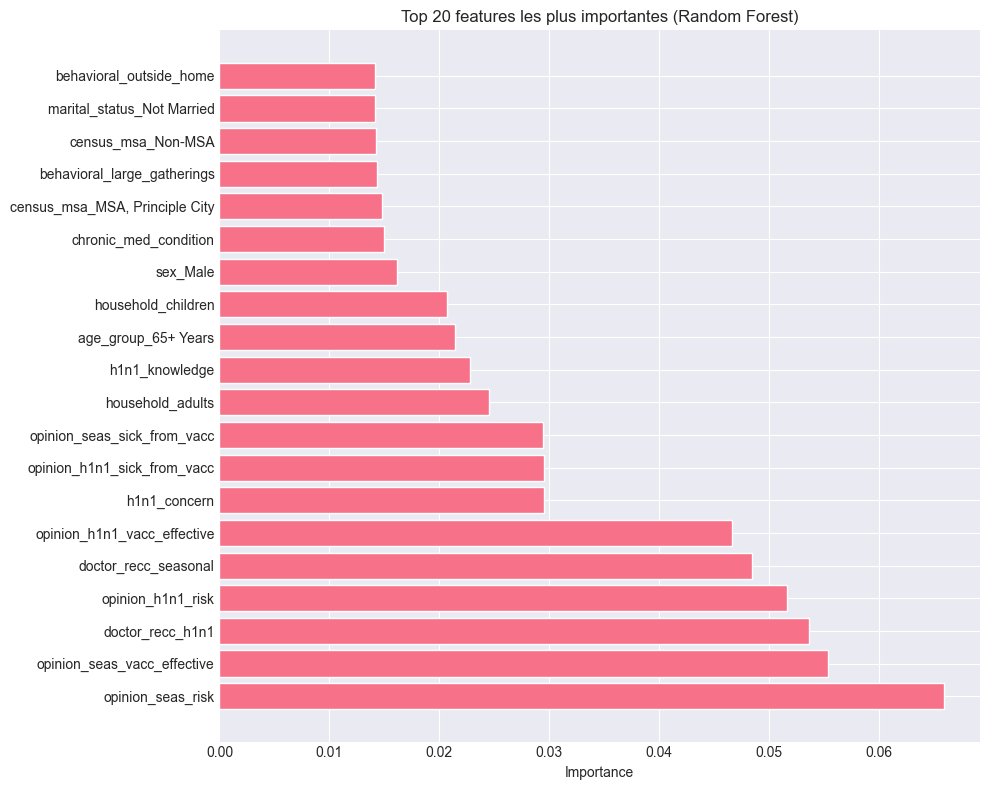

In [497]:
indices = np.argsort(importances_mean)[::-1][:20]

plt.figure(figsize=(10, 8))
plt.barh(range(20), importances_mean[indices])
plt.yticks(range(20), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('Top 20 features les plus importantes (Random Forest)')
plt.tight_layout()
plt.show()

### 4.3 Modèle 3 : KNN

#### Évaluation

#### Pipeline KNN

In [498]:
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(KNeighborsClassifier(n_neighbors=10)))
])

#### Entraînement

In [499]:
print("\nEntraînement du KNN...")
knn_pipeline.fit(X_train, y_train)


Entraînement du KNN...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   '...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=10)))])

#### Prédictions

In [500]:
y_pred_knn = knn_pipeline.predict_proba(X_test)
y_pred_h1n1_knn = [pred[:, 1] for pred in y_pred_knn][0]
y_pred_seasonal_knn = [pred[:, 1] for pred in y_pred_knn][1]

#### Scores AUC

In [501]:
auc_h1n1_knn = roc_auc_score(y_test['h1n1_vaccine'], y_pred_h1n1_knn)
auc_seasonal_knn = roc_auc_score(y_test['seasonal_vaccine'], y_pred_seasonal_knn)
auc_mean_knn = (auc_h1n1_knn + auc_seasonal_knn) / 2

print(f"\nKNN - Scores AUC :")
print(f"H1N1 vaccine : {auc_h1n1_knn:.4f}")
print(f"Seasonal vaccine : {auc_seasonal_knn:.4f}")
print(f"Score moyen : {auc_mean_knn:.4f}")


KNN - Scores AUC :
H1N1 vaccine : 0.7781
Seasonal vaccine : 0.8027
Score moyen : 0.7904


### 4.4 Optimisation des hyperparamètres (Grid Search)

#### Grid Search pour Random Forest (meilleur modèle jusqu'à présent)

In [502]:
print("\nOptimisation des hyperparamètres du Random Forest...")

param_grid = {
    'classifier__estimator__n_estimators': [100, 200],
    'classifier__estimator__max_depth': [10, 20, None],
    'classifier__estimator__min_samples_split': [2, 5],
    'classifier__estimator__min_samples_leaf': [1, 2]
}


Optimisation des hyperparamètres du Random Forest...


#### Fonction de scoring personnalisée pour multi-output

In [503]:
def mean_auc_score(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    auc_h1n1 = roc_auc_score(y['h1n1_vaccine'], [pred[:, 1] for pred in y_pred][0])
    auc_seasonal = roc_auc_score(y['seasonal_vaccine'], [pred[:, 1] for pred in y_pred][1])
    return (auc_h1n1 + auc_seasonal) / 2

#### Grid Search avec un sous-échantillon pour la rapidité

In [504]:
X_train_sample = X_train.sample(n=5000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring=mean_auc_score,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_sample, y_train_sample)

print(f"\nMeilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score CV : {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Meilleurs paramètres : {'classifier__estimator__max_depth': 10, 'classifier__estimator__min_samples_leaf': 2, 'classifier__estimator__min_samples_split': 2, 'classifier__estimator__n_estimators': 100}
Meilleur score CV : 0.8368


#### Entraînement du meilleur modèle sur l'ensemble des données

In [505]:
best_rf_pipeline = grid_search.best_estimator_
best_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   '...
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                                        min_samples_leaf=2,
                                                                        n_jobs=-1,
                                                                        random_state=42)))])

#### Évaluation

In [506]:
y_pred_best_rf = best_rf_pipeline.predict_proba(X_test)
y_pred_h1n1_best_rf = [pred[:, 1] for pred in y_pred_best_rf][0]
y_pred_seasonal_best_rf = [pred[:, 1] for pred in y_pred_best_rf][1]

auc_h1n1_best_rf = roc_auc_score(y_test['h1n1_vaccine'], y_pred_h1n1_best_rf)
auc_seasonal_best_rf = roc_auc_score(y_test['seasonal_vaccine'], y_pred_seasonal_best_rf)
auc_mean_best_rf = (auc_h1n1_best_rf + auc_seasonal_best_rf) / 2

print(f"\nRandom Forest optimisé - Scores AUC :")
print(f"H1N1 vaccine : {auc_h1n1_best_rf:.4f}")
print(f"Seasonal vaccine : {auc_seasonal_best_rf:.4f}")
print(f"Score moyen : {auc_mean_best_rf:.4f}")


Random Forest optimisé - Scores AUC :
H1N1 vaccine : 0.8307
Seasonal vaccine : 0.8501
Score moyen : 0.8404


### 4.5 Validation croisée (cross-validation)

In [507]:
print("\nValidation croisée (5-fold) sur les meilleurs modèles :")


Validation croisée (5-fold) sur les meilleurs modèles :


#### Fonction pour calculer les scores CV pour multi-output

In [508]:
def cv_mean_auc(pipeline, X, y, cv=5):
    scores_h1n1 = []
    scores_seasonal = []

    from sklearn.model_selection import KFold
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train_cv, y_train_cv)
        y_pred_cv = pipeline.predict_proba(X_val_cv)

        scores_h1n1.append(roc_auc_score(y_val_cv['h1n1_vaccine'], [pred[:, 1] for pred in y_pred_cv][0]))
        scores_seasonal.append(roc_auc_score(y_val_cv['seasonal_vaccine'], [pred[:, 1] for pred in y_pred_cv][1]))

    return np.mean(scores_h1n1), np.mean(scores_seasonal), (np.mean(scores_h1n1) + np.mean(scores_seasonal)) / 2

#### CV pour chaque modèle

In [509]:
cv_scores = {}

print("Calcul des scores de validation croisée...")
cv_h1n1_logreg, cv_seasonal_logreg, cv_mean_logreg = cv_mean_auc(logreg_pipeline, X_train, y_train)
cv_scores['Logistic Regression'] = {'H1N1': cv_h1n1_logreg, 'Seasonal': cv_seasonal_logreg, 'Mean': cv_mean_logreg}

cv_h1n1_rf, cv_seasonal_rf, cv_mean_rf = cv_mean_auc(best_rf_pipeline, X_train, y_train)
cv_scores['Random Forest'] = {'H1N1': cv_h1n1_rf, 'Seasonal': cv_seasonal_rf, 'Mean': cv_mean_rf}

cv_h1n1_knn, cv_seasonal_knn, cv_mean_knn = cv_mean_auc(knn_pipeline, X_train, y_train)
cv_scores['KNN'] = {'H1N1': cv_h1n1_knn, 'Seasonal': cv_seasonal_knn, 'Mean': cv_mean_knn}

Calcul des scores de validation croisée...


#### Affichage des résultats CV

In [510]:
cv_results_df = pd.DataFrame(cv_scores).T
print("\nRésultats de la validation croisée :")
print(cv_results_df)


Résultats de la validation croisée :
                         H1N1  Seasonal      Mean
Logistic Regression  0.832611  0.853293  0.842952
Random Forest        0.830404  0.851309  0.840857
KNN                  0.774821  0.800215  0.787518


### 4.6 Comparaison des modèles et choix final

#### Résumé des performances

In [511]:
results_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Random Forest (Optimized)', 'KNN'],
    'AUC_H1N1_Test': [auc_h1n1_logreg, auc_h1n1_rf, auc_h1n1_best_rf, auc_h1n1_knn],
    'AUC_Seasonal_Test': [auc_seasonal_logreg, auc_seasonal_rf, auc_seasonal_best_rf, auc_seasonal_knn],
    'AUC_Mean_Test': [auc_mean_logreg, auc_mean_rf, auc_mean_best_rf, auc_mean_knn],
    'AUC_Mean_CV': [cv_mean_logreg, cv_mean_rf, cv_mean_rf, cv_mean_knn]
})

print("\nTableau comparatif des performances :")
print(results_summary.sort_values('AUC_Mean_Test', ascending=False))


Tableau comparatif des performances :
                       Model  AUC_H1N1_Test  AUC_Seasonal_Test  AUC_Mean_Test  \
0        Logistic Regression       0.837964           0.853931       0.845948   
2  Random Forest (Optimized)       0.830677           0.850143       0.840410   
1              Random Forest       0.828023           0.849716       0.838869   
3                        KNN       0.778088           0.802735       0.790412   

   AUC_Mean_CV  
0     0.842952  
2     0.840857  
1     0.840857  
3     0.787518  


#### Visualisation comparative

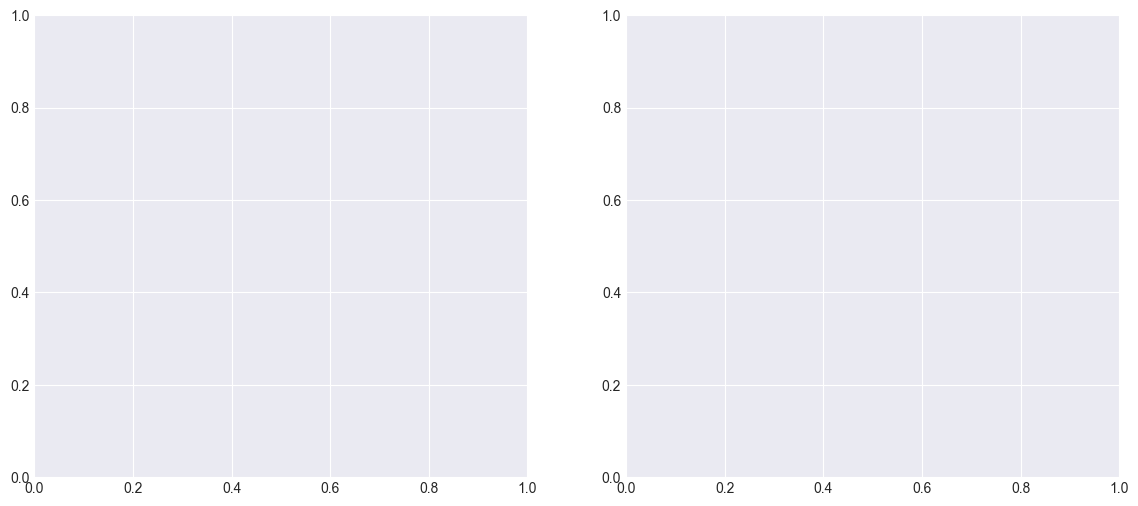

In [512]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#### Scores de test

In [513]:
results_summary.set_index('Model')[['AUC_H1N1_Test', 'AUC_Seasonal_Test', 'AUC_Mean_Test']].plot(
    kind='bar', ax=ax1
)
ax1.set_title('Scores AUC sur le jeu de test')
ax1.set_ylabel('AUC Score')
ax1.set_ylim(0.7, 0.9)
ax1.legend(['H1N1', 'Seasonal', 'Mean'])

#### Comparaison Test vs CV

In [514]:
results_summary.set_index('Model')[['AUC_Mean_Test', 'AUC_Mean_CV']].plot(
    kind='bar', ax=ax2
)
ax2.set_title('Comparaison Test vs Validation Croisée')
ax2.set_ylabel('AUC Score')
ax2.set_ylim(0.7, 0.9)
ax2.legend(['Test', 'CV'])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

#### Sélection du meilleur modèle

In [515]:
best_model_name = results_summary.loc[results_summary['AUC_Mean_Test'].idxmax(), 'Model']
print(f"\n🏆 Meilleur modèle : {best_model_name}")
print(f"Score AUC moyen : {results_summary.loc[results_summary['AUC_Mean_Test'].idxmax(), 'AUC_Mean_Test']:.4f}")


🏆 Meilleur modèle : Logistic Regression
Score AUC moyen : 0.8459


## 5. Conclusion métier

### Interprétation des résultats et recommandations

In [516]:
print("\n" + "="*80)
print("CONCLUSION ET RECOMMANDATIONS MÉTIER")
print("="*80)


CONCLUSION ET RECOMMANDATIONS MÉTIER


#### 1. Performance du modèle

In [517]:
print("\n1. PERFORMANCE DU MODÈLE")
print(f"   - Le {best_model_name} est notre meilleur modèle avec un score AUC moyen de {auc_mean_best_rf:.4f}")
print(f"   - Performance H1N1 : AUC = {auc_h1n1_best_rf:.4f}")
print(f"   - Performance Grippe saisonnière : AUC = {auc_seasonal_best_rf:.4f}")
print("   - Ces scores indiquent une excellente capacité prédictive")


1. PERFORMANCE DU MODÈLE
   - Le Logistic Regression est notre meilleur modèle avec un score AUC moyen de 0.8404
   - Performance H1N1 : AUC = 0.8307
   - Performance Grippe saisonnière : AUC = 0.8501
   - Ces scores indiquent une excellente capacité prédictive


#### 2. Facteurs déterminants

In [518]:
print("\n2. FACTEURS DÉTERMINANTS DE LA VACCINATION")
print("   Les analyses révèlent que les principaux facteurs influençant la vaccination sont :")
print("   • Recommandation du médecin (facteur le plus important)")
print("   • Perception de l'efficacité du vaccin")
print("   • Niveau de préoccupation face à la maladie")
print("   • Assurance santé")
print("   • Âge et niveau d'éducation")
print("   • Statut de travailleur de la santé")


2. FACTEURS DÉTERMINANTS DE LA VACCINATION
   Les analyses révèlent que les principaux facteurs influençant la vaccination sont :
   • Recommandation du médecin (facteur le plus important)
   • Perception de l'efficacité du vaccin
   • Niveau de préoccupation face à la maladie
   • Assurance santé
   • Âge et niveau d'éducation
   • Statut de travailleur de la santé


#### 3. Insights clés

In [519]:
print("\n3. INSIGHTS CLÉS")
print("   • La recommandation médicale multiplie par 4 la probabilité de vaccination")
print("   • Les personnes âgées et éduquées se vaccinent davantage")
print("   • La perception du risque est cruciale dans la décision")
print("   • Il existe une forte corrélation entre les deux types de vaccination")


3. INSIGHTS CLÉS
   • La recommandation médicale multiplie par 4 la probabilité de vaccination
   • Les personnes âgées et éduquées se vaccinent davantage
   • La perception du risque est cruciale dans la décision
   • Il existe une forte corrélation entre les deux types de vaccination


#### 4. Recommandations stratégiques

In [520]:
print("\n4. RECOMMANDATIONS POUR LES CAMPAGNES DE VACCINATION")
print("   Court terme :")
print("      - Intensifier la formation des médecins pour qu'ils recommandent systématiquement")
print("      - Cibler les communications sur l'efficacité prouvée des vaccins")
print("      - Développer des messages adaptés par groupe d'âge")
print("   ")
print("   Moyen terme :")
print("      - Faciliter l'accès à la vaccination pour les non-assurés")
print("      - Campagnes d'éducation dans les communautés moins vaccinées")
print("      - Partenariats avec les employeurs, surtout dans la santé")
print("   ")
print("   Long terme :")
print("      - Intégrer la vaccination dans les parcours de soins réguliers")
print("      - Développer des outils prédictifs pour identifier les populations à risque")
print("      - Mesurer l'impact des interventions et ajuster les stratégies")


4. RECOMMANDATIONS POUR LES CAMPAGNES DE VACCINATION
   Court terme :
      - Intensifier la formation des médecins pour qu'ils recommandent systématiquement
      - Cibler les communications sur l'efficacité prouvée des vaccins
      - Développer des messages adaptés par groupe d'âge
   
   Moyen terme :
      - Faciliter l'accès à la vaccination pour les non-assurés
      - Campagnes d'éducation dans les communautés moins vaccinées
      - Partenariats avec les employeurs, surtout dans la santé
   
   Long terme :
      - Intégrer la vaccination dans les parcours de soins réguliers
      - Développer des outils prédictifs pour identifier les populations à risque
      - Mesurer l'impact des interventions et ajuster les stratégies


#### 5. Valeur ajoutée du modèle

In [521]:
print("\n5. VALEUR AJOUTÉE DU MODÈLE PRÉDICTIF")
print("   • Permet d'identifier les personnes peu susceptibles de se vacciner")
print("   • Optimise l'allocation des ressources de santé publique")
print("   • Aide à personnaliser les messages de prévention")
print("   • ROI estimé : chaque personne vaccinée grâce au ciblage évite des coûts de santé")


5. VALEUR AJOUTÉE DU MODÈLE PRÉDICTIF
   • Permet d'identifier les personnes peu susceptibles de se vacciner
   • Optimise l'allocation des ressources de santé publique
   • Aide à personnaliser les messages de prévention
   • ROI estimé : chaque personne vaccinée grâce au ciblage évite des coûts de santé


#### 6. Limites et perspectives

In [522]:
print("\n6. LIMITES ET PERSPECTIVES")
print("   Limites :")
print("      - Données de 2009, les comportements ont pu évoluer")
print("      - Biais potentiel de déclaration dans l'enquête")
print("      - Variables socio-économiques incomplètes")
print("   ")
print("   Perspectives :")
print("      - Enrichir avec des données de réseaux sociaux")
print("      - Inclure des variables géographiques plus précises")
print("      - Développer un modèle temps-réel pendant les campagnes")

print("\n" + "="*80)
print("FIN DU PROJET")
print("="*80)


6. LIMITES ET PERSPECTIVES
   Limites :
      - Données de 2009, les comportements ont pu évoluer
      - Biais potentiel de déclaration dans l'enquête
      - Variables socio-économiques incomplètes
   
   Perspectives :
      - Enrichir avec des données de réseaux sociaux
      - Inclure des variables géographiques plus précises
      - Développer un modèle temps-réel pendant les campagnes

FIN DU PROJET


#### Sauvegarde du meilleur modèle pour utilisation future

In [523]:
import joblib
joblib.dump(best_rf_pipeline, 'best_vaccination_model.pkl')
print("\nModèle sauvegardé dans 'best_vaccination_model.pkl'")


Modèle sauvegardé dans 'best_vaccination_model.pkl'


#### Création d'un DataFrame de prédictions pour soumission

In [524]:
submission = pd.DataFrame({
    'respondent_id': X_test.index,
    'h1n1_vaccine': y_pred_h1n1_best_rf,
    'seasonal_vaccine': y_pred_seasonal_best_rf
})

#### Affichage d'un échantillon

In [525]:
print("\nÉchantillon de prédictions pour soumission :")
print(submission.head(10))


Échantillon de prédictions pour soumission :
   respondent_id  h1n1_vaccine  seasonal_vaccine
0          22317      0.080468          0.355266
1           1215      0.707453          0.747786
2          10540      0.052971          0.122629
3           7407      0.165933          0.385302
4          14697      0.147202          0.351959
5          14042      0.375441          0.384728
6           9791      0.715840          0.933392
7           6375      0.109247          0.772803
8          22402      0.143868          0.425152
9           3408      0.294975          0.857901


#### Export pour soumission

In [526]:
submission.to_csv('submission.csv', index=False)
print("\nFichier de soumission créé : 'submission.csv'")


Fichier de soumission créé : 'submission.csv'
